In [4]:
import pandas as pd
import numpy as numpy
import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split


# Setting GPU for computation power. Faster results.
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
#Check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

df=pd.read_csv('../data/modelling_dataset_2.csv',index_col=0)

# Data preparation from previous predictive model notebook.
df['channel_sales'] = df['channel_sales'].astype('category')
df = pd.get_dummies(df, columns=['channel_sales'])
df = df.drop(columns=['channel_sales_channel_5', 'channel_sales_channel_6', 'channel_sales_channel_7'])
df['origin_up'] = df['origin_up'].astype('category')
df = pd.get_dummies(df, columns=['origin_up'])
df = df.drop(columns=['origin_up_origin_4', 'origin_up_origin_5'])

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score)
import seaborn as sns
import matplotlib.pyplot as plt

def classification_report_with_confusion_matrix(y_true, y_pred):    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

X =df.drop(columns='churn',axis=1)
y=df['churn']


# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to your data and transform the data
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Num GPUs Available:  1


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
import os
import datetime

# Setup the ModelCheckpoint callback
checkpoint = ModelCheckpoint('../checkpoints/model_epoch_{epoch:02d}.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=False, 
                             save_weights_only=True, 
                             mode='auto', 
                             save_freq='epoch')

# Setup the TensorBoard callback
logdir = os.path.join("../logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)


# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(51,)), 
    Dropout(0.2),
    Dense(16, activation='relu'), 
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# early_stopping = EarlyStopping(monitor='val_loss', 
#                                min_delta=0, 
#                                patience=100,
#                                verbose=1, 
#                                mode='min', 
#                                baseline=None, 
#                                restore_best_weights=True)

# Fit the model with the callbacks
history = model.fit(X_train, y_train, 
                    batch_size=40, 
                    epochs=500, 
                    validation_split=0.2, 
                    verbose=1, 
                    class_weight=class_weight_dict,
                    callbacks=[checkpoint, tensorboard_callback])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")


Model: "sequential_2"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               6656      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 16)                2064      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,737
Trainable params: 8,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
228/234 [============================>.] - ETA: 0s - loss: 0.6861 - accuracy: 0.5706
Epoch 1: saving model to ../checkpoints\model_epoch_01.h5
234/234 [==============================] - 3s 10ms/step - loss: 0.6826 - accuracy: 0.5710 - val_loss: 0.6559 - val_ac

92/92 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      2467
           1       0.30      0.20      0.24       455

    accuracy                           0.80      2922
   macro avg       0.58      0.56      0.56      2922
weighted avg       0.77      0.80      0.79      2922



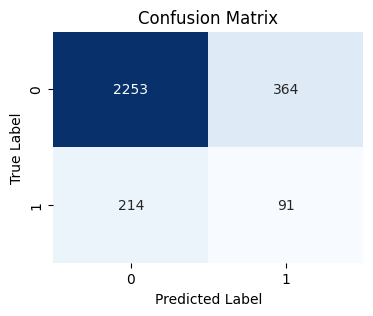

In [6]:
from sklearn.metrics import classification_report
y_pred=model.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)
print(classification_report(y_pred_binary,y_test))
classification_report_with_confusion_matrix(y_test,y_pred_binary)